In [14]:
import numpy as np
import pandas as pd
import random
from joblib import Parallel, delayed
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

Previously used functions

In [2]:
# Optimized function to generate an empty simplicial complex
def generate_empty_simplicial_complex(num_nodes):
    """Generate an empty simplicial complex."""
    nodes = np.arange(1, num_nodes + 1)
    simplicial_complex = {}
    for r in range(1, num_nodes + 1):
        simplices = itertools.combinations(nodes, r)
        for simplex in simplices:
            simplicial_complex[simplex] = 0
    return simplicial_complex

# Optimized function to distribute values for R and S sums
def distribute_value(R_sum, S_sum, nb_of_variables):
    """Distribute values efficiently using NumPy."""
    nb_of_variables_R = random.randint(1, nb_of_variables - 1)
    nb_of_variables_S = nb_of_variables - nb_of_variables_R

    # Generate R and S distributions using numpy for efficiency
    points_R = np.sort(np.random.uniform(0, R_sum, nb_of_variables_R - 1))
    points_R = np.concatenate(([0], points_R, [R_sum]))
    distributed_values_R = np.diff(points_R)

    points_S = np.sort(np.random.uniform(0, S_sum, nb_of_variables_S - 1))
    points_S = np.concatenate(([0], points_S, [S_sum]))
    distributed_values_S = np.diff(points_S)

    # Combine, shuffle, and return the values
    distributed_values = np.concatenate([distributed_values_R, -distributed_values_S])
    np.random.shuffle(distributed_values)

    return distributed_values

# Optimized function to assign MI values
def assign_MI_values(simplicial_complex, R_sum, S_sum):
    """Assign MI values to simplicial complex efficiently."""
    count = sum(1 for key in simplicial_complex if len(key) > 2)
    distributed_values = distribute_value(R_sum, S_sum, count)
    distributed_values_iter = iter(distributed_values)

    for key in simplicial_complex:
        key_length = len(key)
        if key_length == 1:
            simplicial_complex[key] = random.uniform(2, 3)
        elif key_length == 2:
            simplicial_complex[key] = random.uniform(0, 3)
        elif key_length > 2:
            simplicial_complex[key] = next(distributed_values_iter)
    
    return simplicial_complex

# Optimized function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """Compute TSE complexity efficiently."""
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

New functions

In [6]:
# Function to perform simulation for a given R and S
def simulate_TSE(R_sum, S_sum, nb_of_variables, simulations_per_S_R_balance):
    """Simulate TSE calculation for a given R_sum and S_sum."""
    TSE_sum = 0
    for _ in range(simulations_per_S_R_balance):
        empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
        Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
        TSE_value = compute_tse_complexity(Ninfomut_artificial)
        TSE_sum += TSE_value
    TSE_average = TSE_sum / simulations_per_S_R_balance
    return TSE_average

# Parallel processing for the DataFrame assignment
def fill_TSE_df(TSE_df, nb_of_variables, simulations_per_S_R_balance):
    """Fill the TSE DataFrame using parallel processing."""
    rows, cols = TSE_df.index, TSE_df.columns
    results = Parallel(n_jobs=-1)(delayed(simulate_TSE)(int(row), int(col), nb_of_variables, simulations_per_S_R_balance)
                                  for row in rows for col in cols)
    
    result_idx = 0
    for row in rows:
        for col in cols:
            TSE_df.loc[row, col] = results[result_idx]
            result_idx += 1
    return TSE_df

# Remove the top and bottom % of values from a list
def remove_extremes(data):
    """
    Removes the lowest 1% and highest 1% of values from the list.
    
    Parameters:
        data (list or numpy array): The input list of values.
    
    Returns:
        list: A list with the extreme values removed.
    """
    # Convert to a numpy array for easier percentile calculation
    data = np.array(data)
    
    # Calculate the 1st and 99th percentiles
    lower_bound = np.percentile(data, 1)
    upper_bound = np.percentile(data, 99)
    
    # Filter out values outside the range
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    
    return filtered_data

Generate a large number of TSE values for extreme R and S distributions to observe behaviour

In [4]:
TSE_R = []
TSE_S = []
TSE_0 = []

for i in range(1000):
    R_sum = 100
    S_sum = 0
    nb_of_variables = 10

    empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
    Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
    TSE_R.append(compute_tse_complexity(Ninfomut_artificial))

    R_sum = 0
    S_sum = 100
    nb_of_variables = 10

    empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
    Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
    TSE_S.append(compute_tse_complexity(Ninfomut_artificial))

    R_sum = 50
    S_sum = 50
    nb_of_variables = 10

    empty_simplicial_complex = generate_empty_simplicial_complex(nb_of_variables)
    Ninfomut_artificial = assign_MI_values(empty_simplicial_complex, R_sum, S_sum)
    TSE_0.append(compute_tse_complexity(Ninfomut_artificial))

In [7]:
# Remove extreme values
TSE_R_filtered = remove_extremes(TSE_R)
TSE_S_filtered = remove_extremes(TSE_S)
TSE_0_filtered = remove_extremes(TSE_0)

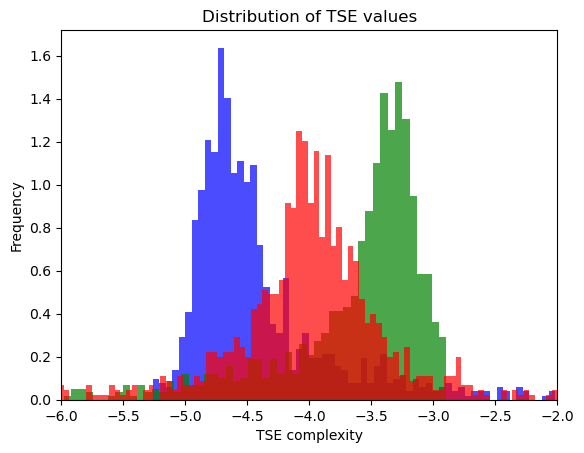

In [10]:
# Plot histograms for the three lists
plt.hist(TSE_R_filtered, bins=100, color='blue', alpha=0.7, label='R dominated networks', density=True)
plt.hist(TSE_S_filtered, bins=100, color='green', alpha=0.7, label='S dominated networks', density=True)
plt.hist(TSE_0_filtered, bins=100, color='red', alpha=0.7, label='Equal S and R', density=True)
plt.xlim(-6, -2)

# IF USEFUL FOR VISUALISATION # Rescale x-axis to make -4 correspond to 0
#ticks = plt.xticks()[0]  # Get current tick positions
#rescaled_ticks = ticks + 4  # Shift ticks by 4
#plt.xticks(ticks, [f"{t}" for t in rescaled_ticks])  # Update tick labels

# Add title and labels
plt.title('Distribution of TSE values')
plt.xlabel('TSE complexity')
plt.ylabel('Frequency')

# Add legend to distinguish the lists
#plt.legend()

# Show the plot
plt.show()

Use functions to generate TSE values for a range of R and S values 

In [12]:
# Main script
nb_of_variables = 10
simulations_per_S_R_balance = 1000
max_R_S_value = 10000
nb_of_R_S_values = 20

# Create empty DataFrame with appropriate row/column labels
stepsize = max_R_S_value / nb_of_R_S_values
max_MI_value = int(max_R_S_value + stepsize)
rows = [f"{i}" for i in np.arange(0, max_MI_value, int(stepsize))]
columns = [f"{j}" for j in np.arange(0, max_MI_value, int(stepsize))]
TSE_df = pd.DataFrame(index=rows, columns=columns)

# Fill the DataFrame in parallel
TSE_df = fill_TSE_df(TSE_df, nb_of_variables, simulations_per_S_R_balance)

Plot the TSE values in a heatmap to visualise the dependence on redundancy and synergy

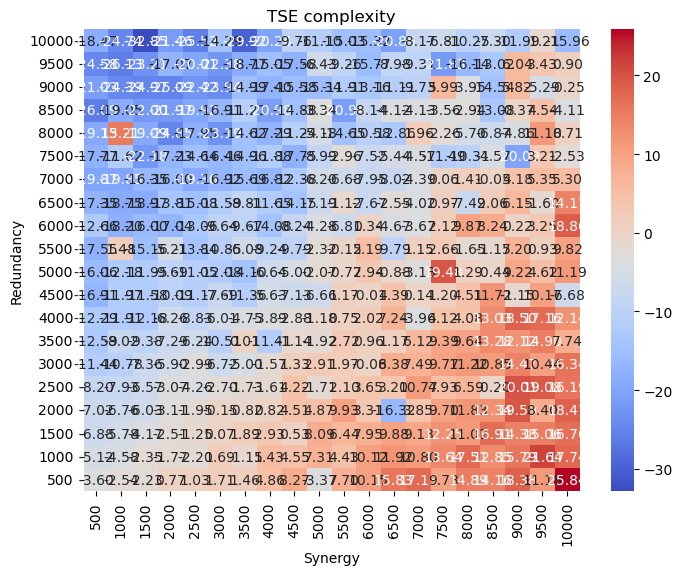

In [15]:
# Ensure the data is numeric
TSE_df = TSE_df.apply(pd.to_numeric, errors='coerce')

# Exclude the first row and column
heatmap_data = TSE_df.iloc[1:, 1:]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)

# Invert the y-axis
plt.gca().invert_yaxis()

# Add title and labels
plt.title("TSE complexity")
plt.xlabel("Synergy")
plt.ylabel("Redundancy")

# Show the plot
plt.show()

Plot the TSE values without printing the values to optimise visibility.

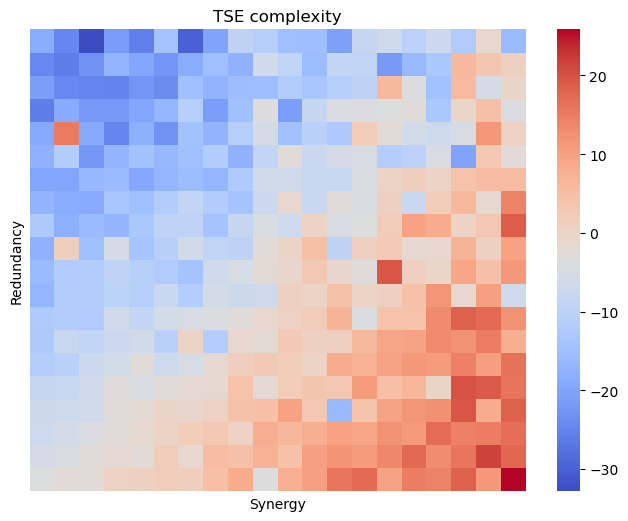

In [16]:
# Ensure the data is numeric
TSE_df = TSE_df.apply(pd.to_numeric, errors='coerce')

# Exclude the first row and column
heatmap_data = TSE_df.iloc[1:, 1:]

# Plot the heatmap without annotations
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=False, cmap="coolwarm", cbar=True)

# Invert the y-axis
plt.gca().invert_yaxis()

# Hide the axis ticks but keep the labels
plt.xticks([])  # Hide x-axis ticks
plt.yticks([])  # Hide y-axis ticks

# Add title with axis labels
plt.title("TSE complexity")
plt.xlabel("Synergy")
plt.ylabel("Redundancy")

# Show the plot
plt.show()